# Preparación de los datos para los modelos de predicción
En este notebook se unirán los datasets necesarios para la elaboración de los modelos de predicción basados en los datos acumulados de:

**Radiación del día anterior a la llamada** https://opendata.aemet.es/centrodedescargas/productosAEMET<br>
**Radiación solar de dos días antes del día de obtención de datos** http://www.soda-pro.com/web-services/radiation/cams-radiation-service<br>
**Datos climáticos de los cinco días anteriores a la llamada** https://openweathermap.org/api/one-call-api#history<br>
**Predicción climática de los dos días siguientes a la llamada** https://openweathermap.org/api/one-call-api<br>


- [Preparación](#Preparación)<br>

### 1. [Preparación de datos históricos de clima](#Preparación-de-datos-históricos-de-clima)

### 2. [Preparación de predicciones de clima](#Preparación-de-predicciones-de-clima)

### 3. [Preparación de datos de radiación del día anterior](#Preparación-de-datos-de-radiación-del-día-anterior)

### 4. [Preparación de datos históricos de radiación](#Preparación-de-datos-históricos-de-radiación)

### 5. [Unión de datasets](#Unión-de-datasets)

### 6. [Función final](#Función-final)


## Nota previa
Para poder ejecutar el script adecuadamente hay que utilizar la siguiente línea de comando para abrir el notebook desde la terminal:

In [1]:
#jupyter-lab --NotebookApp.iopub_data_rate_limit=1.0e15

**PRECAUCIÓN:** Tarda horas en correr

### Preparación

In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None
hora_ini = 4
hora_fin = 20

Se fija el directorio de trabajo

In [3]:
%cd /home/dsc/git/TFM/

/home/dsc/git/TFM


In [4]:
directorio = '/home/dsc/git/TFM/'

Funcion que calcula la distancia euclidea o de Manhattan entre dos puntos

In [5]:
import math 

def distancia(lat1, lon1, lat2, lon2, distancia = "euclidea"):
    
    if(distancia == "euclidea"):
        dist = math.sqrt((lat1 - lat2)**2 + (lon1 -lon2)**2)
    
    elif(distancia == "manhattan"):
        dist = abs(lat1 - lat2) + abs(lon1 -lon2)
  
    return dist 

Función que transforma coordenadas de GMS a decimal

In [6]:
def conversor_coordenadas(coord):
    #Si coord es latitud, al norte del ecuador es siempre positiva
    #Si coord es longitud, al oeste del Meridiano 0º son negativas
    
    D = int(coord[0:2])
    M = float(coord[2:4])
    S = float(coord[4:6])
    
    #GMS a GD
    DD = float((D) + (M/60) + (S/3600))
        
    if(coord[6] == "S" or coord[6] == "W"):
            DD = -DD
            
    return DD

# Preparación de datos históricos de clima
<div style = "float:right"><a style="text-decoration:none" href = "#Preparación-de-los-datos-para-los-modelos-de-predicción">

Se importa el dataset de datos históricos de clima (donde para cada día que se obtienen los datos se guardan en filas diferentes los distintos datos)

In [7]:
df_clima = pd.read_csv('./data/Historicos_modelo_2/historicos_climaticos_clean.csv', sep=',')

df_clima.head()

,date,hour,fecha prediccion,estacion,temp,feels_like,pressure,humidity,dew_point,clouds,visibility,wind_speed,wind_deg,wind_gust,we
0,2021-04-04,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.782415,800
1,2021-04-04,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.782415,800
2,2021-04-04,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.782415,800
3,2021-04-04,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.782415,800
4,2021-04-04,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.782415,800


In [8]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362000 entries, 0 to 1361999
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date              1362000 non-null  object 
 1   hour              1362000 non-null  int64  
 2   fecha prediccion  1362000 non-null  object 
 3   estacion          1362000 non-null  object 
 4   temp              1362000 non-null  float64
 5   feels_like        1362000 non-null  float64
 6   pressure          1362000 non-null  int64  
 7   humidity          1362000 non-null  int64  
 8   dew_point         1362000 non-null  float64
 9   clouds            1362000 non-null  int64  
 10  visibility        1362000 non-null  float64
 11  wind_speed        1362000 non-null  float64
 12  wind_deg          1362000 non-null  int64  
 13  wind_gust         1362000 non-null  float64
 14  we                1362000 non-null  int64  
dtypes: float64(6), int64(6), object(3)
memory usage: 

Observamos que la mayor parte de días tienen porcentajes de cielo cubierto por nubes concretos.

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


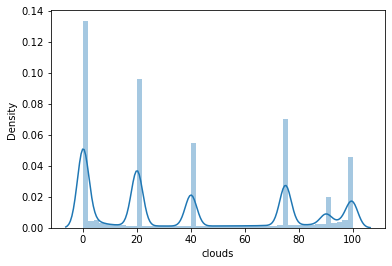

In [9]:
sns.distplot(df_clima["clouds"]);

Se puede comprobar que la temperatura media se centra entr los 275 y 300 Kº (2-27 ºC), valores razonables

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


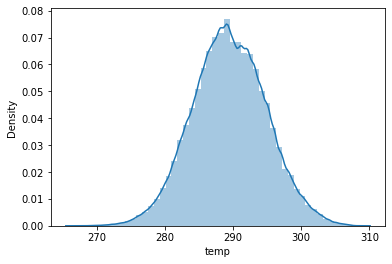

In [10]:
sns.distplot(df_clima["temp"]);

Se puede comprobar que la velocidad media de viento es de 3,5 m/s, valores razonables

In [11]:
np.mean(df_clima["wind_speed"])

3.524774926574907

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


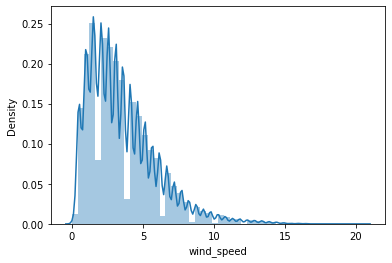

In [12]:
sns.distplot(df_clima["wind_speed"]);

Se puede comprobar que el ID de clima contiene claros picos en valores singulares. Por ejemplo, 800 significa cielo despejado.

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


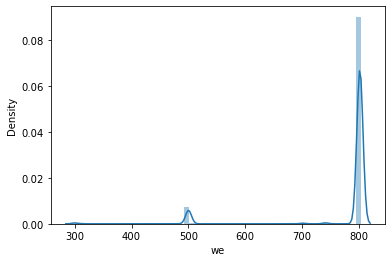

In [13]:
sns.distplot(df_clima["we"]);

Se puede comprobar que no existe una correlación clara entre el tipo de clima y la temperatura media de un día

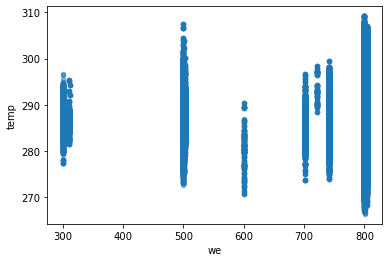

In [14]:
var1 = "we"
var2 = "temp"
data = pd.concat([df_clima[var2], df_clima[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

Se puede comprobar que existe una correlación positiva entre la sensación térmica y la temperatura media de un día

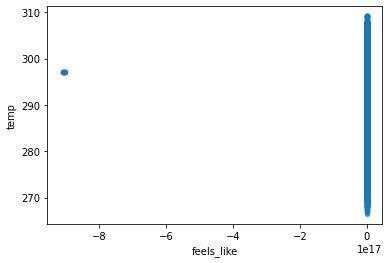

In [15]:
var1 = "feels_like"
var2 = "temp"
data = pd.concat([df_clima[var2], df_clima[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

No parece que exista correlación clara entre la velocidad media de viento de un día y la temperatura media de este

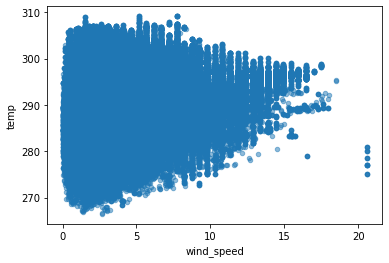

In [16]:
var1 = "wind_speed"
var2 = "temp"
data = pd.concat([df_clima[var2], df_clima[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

Se importa el dataset de datos históricos de clima (donde para cada día que se obtienen los datos se guardan en columnas diferentes los datos de diferentes días)

In [17]:
df_clima = pd.read_csv('./data/Historicos_modelo_2/clima_por_horas.csv', sep=',')

df_clima.head()

,hour,fecha prediccion,estacion,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,285.17,283.96,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,284.75,282.73,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,282.28,280.06,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,284.67,282.93,1026,68,278.98,42,9770.795014,1.12,338,1.18,802
1,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.782415,800,284.66,283.21,1012,81,281.52,0,10000.0,1.54,320,4.782415,800,283.71,282.39,1014,81,280.59,0,10000.0,1.03,0,4.782415,800,281.30,279.00,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,284.59,282.86,1026,67,278.69,50,9770.795014,1.02,336,1.10,800
2,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.782415,800,285.18,284.34,1012,76,281.09,0,10000.0,0.51,0,4.782415,800,285.04,283.22,1014,71,279.96,0,10000.0,1.54,300,4.782415,800,281.42,279.47,1020,87,279.39,0,10000.0,1.54,280,4.782415,800,284.61,282.96,1026,68,278.92,41,9770.795014,0.97,324,1.07,802
3,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.782415,800,287.22,286.25,1012,71,282.05,0,10000.0,1.03,0,4.782415,800,285.78,283.43,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,284.12,282.78,1021,70,278.87,0,10000.0,0.51,0,4.782415,800,286.04,284.80,1026,64,279.40,47,9770.795014,0.54,329,0.85,802
4,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.782415,800,288.86,287.74,1013,55,279.85,0,10000.0,0.51,0,4.782415,800,288.53,287.51,1015,58,280.32,0,10000.0,0.51,0,4.782415,800,286.82,285.25,1021,54,277.69,0,10000.0,0.51,150,4.782415,800,287.52,286.42,1026,58,279.37,54,9770.795014,0.32,121,0.67,803


Se añade una columna con la fecha del día siguiente al del que se obtienen los datos, ya que este será el día para el que se desea predecir la radiación a partir de estos

In [18]:
import datetime
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha prediccion"]]
df_clima.insert(0, "fecha_rad", fechas_atrasadas, True)
df_clima.head()

,fecha_rad,hour,fecha prediccion,estacion,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,285.17,283.96,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,284.75,282.73,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,282.28,280.06,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,284.67,282.93,1026,68,278.98,42,9770.795014,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.782415,800,284.66,283.21,1012,81,281.52,0,10000.0,1.54,320,4.782415,800,283.71,282.39,1014,81,280.59,0,10000.0,1.03,0,4.782415,800,281.30,279.00,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,284.59,282.86,1026,67,278.69,50,9770.795014,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.782415,800,285.18,284.34,1012,76,281.09,0,10000.0,0.51,0,4.782415,800,285.04,283.22,1014,71,279.96,0,10000.0,1.54,300,4.782415,800,281.42,279.47,1020,87,279.39,0,10000.0,1.54,280,4.782415,800,284.61,282.96,1026,68,278.92,41,9770.795014,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.782415,800,287.22,286.25,1012,71,282.05,0,10000.0,1.03,0,4.782415,800,285.78,283.43,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,284.12,282.78,1021,70,278.87,0,10000.0,0.51,0,4.782415,800,286.04,284.80,1026,64,279.40,47,9770.795014,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.782415,800,288.86,287.74,1013,55,279.85,0,10000.0,0.51,0,4.782415,800,288.53,287.51,1015,58,280.32,0,10000.0,0.51,0,4.782415,800,286.82,285.25,1021,54,277.69,0,10000.0,0.51,150,4.782415,800,287.52,286.42,1026,58,279.37,54,9770.795014,0.32,121,0.67,803


Se renombran las columnas necesarias

In [19]:
df_clima = df_clima.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
df_clima.head()

,fecha_rad,hora,fecha prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,285.17,283.96,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,284.75,282.73,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,282.28,280.06,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,284.67,282.93,1026,68,278.98,42,9770.795014,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.782415,800,284.66,283.21,1012,81,281.52,0,10000.0,1.54,320,4.782415,800,283.71,282.39,1014,81,280.59,0,10000.0,1.03,0,4.782415,800,281.30,279.00,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,284.59,282.86,1026,67,278.69,50,9770.795014,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.782415,800,285.18,284.34,1012,76,281.09,0,10000.0,0.51,0,4.782415,800,285.04,283.22,1014,71,279.96,0,10000.0,1.54,300,4.782415,800,281.42,279.47,1020,87,279.39,0,10000.0,1.54,280,4.782415,800,284.61,282.96,1026,68,278.92,41,9770.795014,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.782415,800,287.22,286.25,1012,71,282.05,0,10000.0,1.03,0,4.782415,800,285.78,283.43,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,284.12,282.78,1021,70,278.87,0,10000.0,0.51,0,4.782415,800,286.04,284.80,1026,64,279.40,47,9770.795014,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.782415,800,288.86,287.74,1013,55,279.85,0,10000.0,0.51,0,4.782415,800,288.53,287.51,1015,58,280.32,0,10000.0,0.51,0,4.782415,800,286.82,285.25,1021,54,277.69,0,10000.0,0.51,150,4.782415,800,287.52,286.42,1026,58,279.37,54,9770.795014,0.32,121,0.67,803


Se convierten los grados Kelvin en Cº

In [20]:
df_clima["temp_d-1"] = df_clima["temp_d-1"] - 273.15
df_clima["temp_d-2"] = df_clima["temp_d-2"] - 273.15
df_clima["temp_d-3"] = df_clima["temp_d-3"] - 273.15
df_clima["temp_d-4"] = df_clima["temp_d-4"] - 273.15
df_clima["temp_d-5"] = df_clima["temp_d-5"] - 273.15

df_clima["feels_like_d-1"] = df_clima["feels_like_d-1"] - 273.15
df_clima["feels_like_d-2"] = df_clima["feels_like_d-2"] - 273.15
df_clima["feels_like_d-3"] = df_clima["feels_like_d-3"] - 273.15
df_clima["feels_like_d-4"] = df_clima["feels_like_d-4"] - 273.15
df_clima["feels_like_d-5"] = df_clima["feels_like_d-5"] - 273.15

df_clima.head()

,fecha_rad,hora,fecha prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,11.52,9.78,1026,68,278.98,42,9770.795014,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.782415,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.782415,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.782415,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9770.795014,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.782415,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.782415,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.782415,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.782415,800,11.46,9.81,1026,68,278.92,41,9770.795014,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.782415,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.782415,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.782415,800,12.89,11.65,1026,64,279.40,47,9770.795014,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.782415,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.782415,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.782415,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.782415,800,14.37,13.27,1026,58,279.37,54,9770.795014,0.32,121,0.67,803


Genero el dataset de la variable objetivo temperatura ambiente. Esta variable también se predecirá (para poder obtener la producción fotovoltaica de una instalación). Esta variable será la obtenidas para el día anterior al de cada llamada (d-1), asociada a la fecha del día que se registró.

In [21]:
import datetime

# Creo el nuevo dataframe con las columnas necesarias
df_objetivos = pd.DataFrame(columns = ["hora", "indicativo", "temp_objetivo"])
df_objetivos["hora"] = df_clima["hora"]
df_objetivos["indicativo"] = df_clima["indicativo"]
df_objetivos["temp_objetivo"] = df_clima["temp_d-1"]

# Asocio los valores a la fecha del día que se registraron (el anterior a la obtención de los datos)
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) - datetime.timedelta(days=1)).year), str((pd.to_datetime(f) - datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) - datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha prediccion"]]
df_objetivos.insert(0, "fecha_rad", fechas_atrasadas, True)

df_objetivos.head()

,fecha_rad,hora,indicativo,temp_objetivo
0,2021-04-04,4,0252D,11.15
1,2021-04-04,5,0252D,11.44
2,2021-04-04,6,0252D,11.26
3,2021-04-04,7,0252D,11.84
4,2021-04-04,8,0252D,13.26


Por otro lado, los datos de radiación de AEMET solo están disponibles para las diferentes estaciones de radiación. Por ello, se debe tomar el dato de la estación más cercana al punto a estudiar (los diferentes puntos de datos corresponden a las estaciones meteorológicas, no de radiación).

In [22]:
# Cargo los datos de las estaciones meteorológicas
df_estaciones = pd.read_csv(directorio + 'data/estaciones.csv')
df_estaciones.head()

,latitud,provincia,altitud,indicativo,nombre,longitud
0,413515N,BARCELONA,74,0252D,ARENYS DE MAR,023224E
1,411734N,BARCELONA,4,0076,BARCELONA AEROPUERTO,020412E
2,412506N,BARCELONA,408,0200E,"BARCELONA, FABRA",020727E
3,412326N,BARCELONA,6,0201D,BARCELONA,021200E
4,414312N,BARCELONA,291,0149X,MANRESA,015025E


In [23]:
# Cargo los datos de las estaciones de radiación
df_estaciones_rad = pd.read_csv(directorio + 'data/estaciones_rad.csv')
df_estaciones_rad.dropna(inplace = True)
df_estaciones_rad.reset_index(drop = True, inplace = True)
df_estaciones_rad.head()

,Estación,indicativo,latitud,longitud
0,b'A Coru\xc3\xb1a',1387,432157N,082517W
1,b'Albacete',8178D,390020N,015144W
2,b'Almer\xc3\xada Aeropuerto',6325O,365047N,022125W
3,b'Badajoz',4478G,413800N,005256W
4,b'Barcelona',0201D,412326N,021200E


Se añade una columna con los indicativos de la estación de radiación más cercana a cada estación meteorológica

Se añaden además, como variables, la latitud y la longitud del punto estudiado

In [24]:
df_clima.head()

,fecha_rad,hora,fecha prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,11.52,9.78,1026,68,278.98,42,9770.795014,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.782415,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.782415,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.782415,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9770.795014,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.782415,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.782415,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.782415,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.782415,800,11.46,9.81,1026,68,278.92,41,9770.795014,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.782415,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.782415,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.782415,800,12.89,11.65,1026,64,279.40,47,9770.795014,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.782415,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.782415,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.782415,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.782415,800,14.37,13.27,1026,58,279.37,54,9770.795014,0.32,121,0.67,803


**PRECAUCIÓN:** Tarda horas en correr

In [25]:
# Para cada fila, busco la estación de radiación asociada y sus coordenadas
df_clima["indicativo_rad"] = np.nan
df_clima["lat"] = np.nan
df_clima["lon"] = np.nan

for i, fila in df_clima.iterrows():
    
    if int(i) in list(range(0, len(df_clima["indicativo"]), int(len(df_clima["indicativo"])/50))):
        print("{}/{}".format(i, len(df_clima["indicativo"])))
    
    j = list(df_estaciones["indicativo"]).index(fila["indicativo"])
    
    # Se añaden la latitud y longitud de la estación 
    lat = conversor_coordenadas(str(df_estaciones.loc[j, "latitud"])) 
    lon = conversor_coordenadas(str(df_estaciones.loc[j, "longitud"]))
    df_clima.loc[i,"lat"] = lat
    df_clima.loc[i,"lon"] = lon
    
    dist = 99999999999999999999
            
    # Para cada fila, se busca la estacion de radiación más cercana
    for k in range(0, len(df_estaciones_rad["indicativo"])): 
        lat_est = conversor_coordenadas(str(df_estaciones_rad["latitud"].loc[k]))
        lon_est = conversor_coordenadas(str(df_estaciones_rad["longitud"].loc[k]))
                
        distancia_prueba = distancia(lat, lon, lat_est, lon_est)
        if(distancia_prueba < dist):
            dist = distancia_prueba
            df_clima.loc[i,"indicativo_rad"] = df_estaciones_rad.loc[k, "indicativo"]
            
df_clima.head()

0/272352
5447/272352
10894/272352
16341/272352
21788/272352
27235/272352
32682/272352
38129/272352
43576/272352
49023/272352
54470/272352
59917/272352
65364/272352
70811/272352
76258/272352
81705/272352
87152/272352
92599/272352
98046/272352
103493/272352
108940/272352
114387/272352
119834/272352
125281/272352
130728/272352
136175/272352
141622/272352
147069/272352
152516/272352
157963/272352
163410/272352
168857/272352
174304/272352
179751/272352
185198/272352
190645/272352
196092/272352
201539/272352
206986/272352
212433/272352
217880/272352
223327/272352
228774/272352
234221/272352
239668/272352
245115/272352
250562/272352
256009/272352
261456/272352
266903/272352
272350/272352


,fecha_rad,hora,fecha prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon
0,2021-04-06,4,2021-04-05,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,11.52,9.78,1026,68,278.98,42,9770.795014,1.12,338,1.18,802,0201D,41.5875,2.54
1,2021-04-06,5,2021-04-05,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.782415,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.782415,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.782415,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9770.795014,1.02,336,1.10,800,0201D,41.5875,2.54
2,2021-04-06,6,2021-04-05,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.782415,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.782415,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.782415,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.782415,800,11.46,9.81,1026,68,278.92,41,9770.795014,0.97,324,1.07,802,0201D,41.5875,2.54
3,2021-04-06,7,2021-04-05,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.782415,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.782415,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.782415,800,12.89,11.65,1026,64,279.40,47,9770.795014,0.54,329,0.85,802,0201D,41.5875,2.54
4,2021-04-06,8,2021-04-05,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.782415,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.782415,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.782415,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.782415,800,14.37,13.27,1026,58,279.37,54,9770.795014,0.32,121,0.67,803,0201D,41.5875,2.54


# Preparación de predicciones de clima
<div style = "float:right"><a style="text-decoration:none" href = "#Preparación-de-los-datos-para-los-modelos-de-predicción">

Se importa el dataset de datos históricos de predicciones de clima (donde para cada día que se obtienen los datos se guardan en filas diferentes los distintos datos)

In [26]:
df_pred = pd.read_csv('./data/Historicos_modelo_2/predicciones_climaticas_clean.csv', sep=',')

df_pred.head()

,date,hour,fecha prediccion,estacion,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,pop,we
0,2021-04-05,4,2021-04-05,0252D,285.47,284.66,1017,73,280.28,0.00,63,10000,0.98,306,1.36,0.0,803
1,2021-04-05,5,2021-04-05,0252D,285.54,284.66,1017,70,279.91,0.00,65,10000,1.18,10,1.43,0.0,803
2,2021-04-05,6,2021-04-05,0252D,285.31,284.44,1018,71,279.75,0.11,61,10000,1.73,34,1.71,0.0,803
3,2021-04-05,7,2021-04-05,0252D,286.09,285.19,1017,67,279.64,0.55,16,10000,1.52,58,1.76,0.0,801
4,2021-04-05,8,2021-04-05,0252D,287.24,286.32,1017,62,279.58,1.46,10,10000,0.94,103,1.28,0.0,800


In [27]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549208 entries, 0 to 549207
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              549208 non-null  object 
 1   hour              549208 non-null  int64  
 2   fecha prediccion  549208 non-null  object 
 3   estacion          549208 non-null  object 
 4   temp              549208 non-null  float64
 5   feels_like        549208 non-null  float64
 6   pressure          549208 non-null  int64  
 7   humidity          549208 non-null  int64  
 8   dew_point         549208 non-null  float64
 9   uvi               549208 non-null  float64
 10  clouds            549208 non-null  int64  
 11  visibility        549208 non-null  int64  
 12  wind_speed        549208 non-null  float64
 13  wind_deg          549208 non-null  int64  
 14  wind_gust         549208 non-null  float64
 15  pop               549208 non-null  float64
 16  we                54

Observamos que la mayor parte de días tienen porcentajes de cielo cubierto por nubes concretos.

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


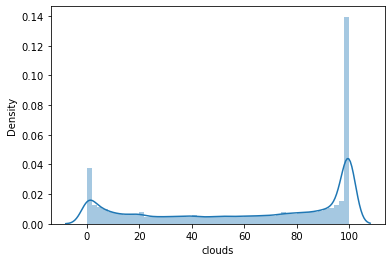

In [28]:
sns.distplot(df_pred["clouds"]);

Se puede comprobar que la temperatura media se centra entr los 275 y 300 Kº (2-27 ºC), valores razonables

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


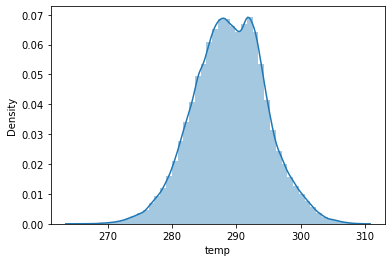

In [29]:
sns.distplot(df_pred["temp"]);

Se puede comprobar que la velocidad media de viento se centra en 2,5 m/s, valores razonables

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


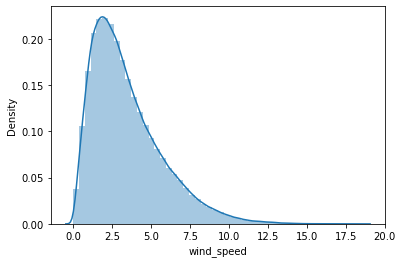

In [30]:
sns.distplot(df_pred["wind_speed"]);

Se puede comprobar que el ID de clima contiene claros picos en valores singulares. Por ejemplo, 800 significa cielo despejado.

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


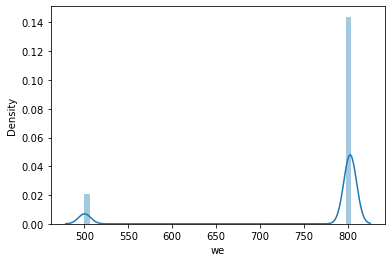

In [31]:
sns.distplot(df_pred["we"]);

Se puede comprobar que no existe una correlación clara entre el tipo de clima y la temperatura media de un día

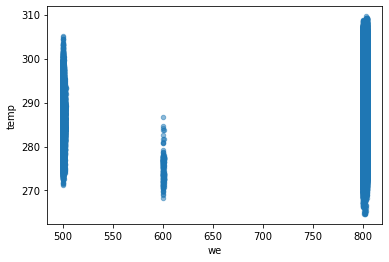

In [32]:
var1 = "we"
var2 = "temp"
data = pd.concat([df_pred[var2], df_pred[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

Se puede comprobar que existe una correlación positiva entre la sensación térmica y la temperatura media de un día

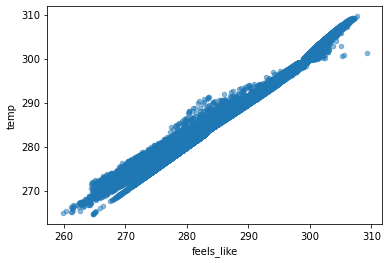

In [33]:
var1 = "feels_like"
var2 = "temp"
data = pd.concat([df_pred[var2], df_pred[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

No parece que exista correlación clara entre la velocidad media de viento de un día y la temperatura media de este

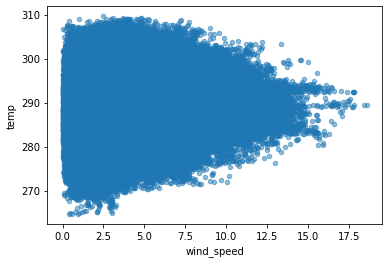

In [34]:
var1 = "wind_speed"
var2 = "temp"
data = pd.concat([df_pred[var2], df_pred[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

Se importa el dataset de datos históricos de predicciones de clima (donde para cada día que se obtienen los datos se guardan en columnas diferentes los datos de diferentes días)

In [35]:
df_pred = pd.read_csv('./data/Historicos_modelo_2/pred_por_horas.csv', sep=',')

df_pred.head()

,hour,fecha prediccion,estacion,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,4,2021-04-05,0252D,284.875,284.110,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,5,2021-04-05,0252D,284.910,284.150,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,6,2021-04-05,0252D,285.120,284.400,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,7,2021-04-05,0252D,285.930,285.195,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,8,2021-04-05,0252D,286.500,285.755,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


Se convierten los grados Kelvin en Cº

In [36]:
df_pred["temp_pred"] = df_pred["temp_pred"] - 273.15
df_pred["feels_like_pred"] = df_pred["feels_like_pred"] - 273.15

df_pred.head()

,hour,fecha prediccion,estacion,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,4,2021-04-05,0252D,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,5,2021-04-05,0252D,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,6,2021-04-05,0252D,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,7,2021-04-05,0252D,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,8,2021-04-05,0252D,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


Se añade una columna con la fecha del día siguiente al día que se obtienen los datos, ya que este será el día para el que se desea predecir la radiación a partir de estos

In [37]:
import datetime
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_pred["fecha prediccion"]]
df_pred.insert(0, "fecha_rad", fechas_atrasadas, True)
df_pred.head()

,fecha_rad,hour,fecha prediccion,estacion,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,2021-04-06,4,2021-04-05,0252D,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,2021-04-06,5,2021-04-05,0252D,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,2021-04-06,6,2021-04-05,0252D,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,2021-04-06,7,2021-04-05,0252D,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,2021-04-06,8,2021-04-05,0252D,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


Se renombran las columnas necesarias

In [38]:
df_pred = df_pred.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
df_pred.head()

,fecha_rad,hora,fecha prediccion,indicativo,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,2021-04-06,4,2021-04-05,0252D,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,2021-04-06,5,2021-04-05,0252D,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,2021-04-06,6,2021-04-05,0252D,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,2021-04-06,7,2021-04-05,0252D,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,2021-04-06,8,2021-04-05,0252D,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


# Preparación de datos de radiación del día anterior
<div style = "float:right"><a style="text-decoration:none" href = "#Preparación-de-los-datos-para-los-modelos-de-predicción">

Se importa el dataset de datos históricos de radiación en las estaciones de readiación de AEMET

In [39]:
df_aemet = pd.read_csv('./data/Historicos_modelo_2/rad_aemet_clean.csv', sep=',')

df_aemet.head()

,fecha,hora,estacion,indicativo,GL,UVB,IR
0,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


In [40]:
df_aemet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32106 entries, 0 to 32105
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fecha       32106 non-null  object 
 1   hora        32106 non-null  int64  
 2   estacion    32106 non-null  object 
 3   indicativo  32106 non-null  object 
 4   GL          32106 non-null  float64
 5   UVB         32106 non-null  float64
 6   IR          32106 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.7+ MB


Se renombra la columna necesaria

In [41]:
df_aemet = df_aemet.rename(columns={'indicativo':'indicativo_rad'})
df_aemet.head()

,fecha,hora,estacion,indicativo_rad,GL,UVB,IR
0,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


Observamos la distribución de valores de radiación, con muchos valores nulos de las horas nocturnas.

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


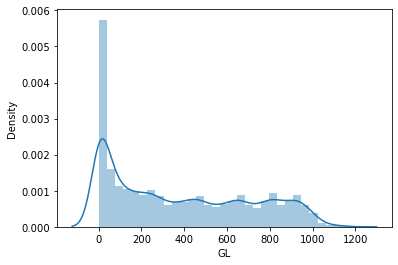

In [42]:
sns.distplot(df_aemet["GL"]);

Se observa claramente la distribución de valores de radiación por hora, con máximos a mediodía y valores nulos en horas de madrugada y anochecer

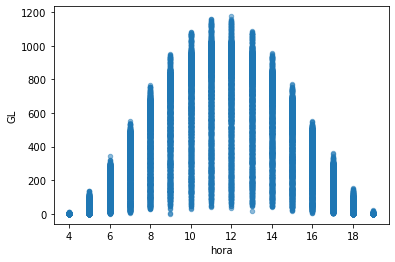

In [43]:
var1 = "hora"
var2 = "GL"
data = pd.concat([df_aemet[var2], df_aemet[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

Se añade una columna con la fecha del día siguiente al que se obtuvieron los datos, ya que este será el día para el que se desea predecir la radiación a partir de estos

In [44]:
import datetime
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=2)).year), str((pd.to_datetime(f) + datetime.timedelta(days=2)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=2)).day).zfill(2)) for f in df_aemet["fecha"]]
df_aemet.insert(0, "fecha_rad", fechas_atrasadas, True)
df_aemet.head()

,fecha_rad,fecha,hora,estacion,indicativo_rad,GL,UVB,IR
0,2021-04-06,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-06,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-06,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-06,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-06,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


Se renombran las columnas necesarias

In [45]:
df_aemet = df_aemet.rename(columns={'GL': 'rad_d-1', 'UVB': 'uvb_d-1', 'IR': 'ir_d-1'})
df_aemet.head()

,fecha_rad,fecha,hora,estacion,indicativo_rad,rad_d-1,uvb_d-1,ir_d-1
0,2021-04-06,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-06,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-06,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-06,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-06,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


# Preparación de datos históricos de radiación
<div style = "float:right"><a style="text-decoration:none" href = "#Preparación-de-los-datos-para-los-modelos-de-predicción">

Se carga el dataframe de datos históricos de radiación de CAMS SODA

In [46]:
df_soda = pd.read_csv('./data/Historicos_modelo_2/rad_soda_clean.csv', sep=',')

df_soda.head()

,date,ghi,estacion,hora,fecha
0,2021-04-05 04:00:00,0.0000,0252D,4,2021-04-05
1,2021-04-05 05:00:00,6.3289,0252D,5,2021-04-05
2,2021-04-05 06:00:00,120.0964,0252D,6,2021-04-05
3,2021-04-05 07:00:00,303.6657,0252D,7,2021-04-05
4,2021-04-05 08:00:00,484.0124,0252D,8,2021-04-05


Se renombran las columnas necesarias

In [47]:
df_soda = df_soda.rename(index = str, columns = {"estacion": "indicativo", "fecha": "fecha_rad"})

In [48]:
df_soda.shape

(207440, 5)

In [49]:
df_soda.head()

,date,ghi,indicativo,hora,fecha_rad
0,2021-04-05 04:00:00,0.0000,0252D,4,2021-04-05
1,2021-04-05 05:00:00,6.3289,0252D,5,2021-04-05
2,2021-04-05 06:00:00,120.0964,0252D,6,2021-04-05
3,2021-04-05 07:00:00,303.6657,0252D,7,2021-04-05
4,2021-04-05 08:00:00,484.0124,0252D,8,2021-04-05


Se elimina la columna innecesaria

In [50]:
df_soda.drop(['date'], axis=1, inplace = True)

La variable objetivo de radiación es también la la radiación horaria de dos días antes del de la obtención de datos, una de las entradas del modelo. Para ello, se crea un nuevo dataset con los valores de radiación, asociados a 2 días después del valor registrado

In [51]:
import datetime

df_rad_2 = pd.DataFrame(columns = ["indicativo", "hora", "rad_d-2"])
df_rad_2["indicativo"] = df_soda["indicativo"]
df_rad_2["hora"] = df_soda["hora"]
df_rad_2["rad_d-2"] = df_soda["ghi"]

fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=3)).year), str((pd.to_datetime(f) + datetime.timedelta(days=3)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=3)).day).zfill(2)) for f in df_soda["fecha_rad"]]
df_rad_2.insert(0, "fecha_rad", fechas_atrasadas, True)

df_rad_2.head()

,fecha_rad,indicativo,hora,rad_d-2
0,2021-04-08,0252D,4,0.0000
1,2021-04-08,0252D,5,6.3289
2,2021-04-08,0252D,6,120.0964
3,2021-04-08,0252D,7,303.6657
4,2021-04-08,0252D,8,484.0124


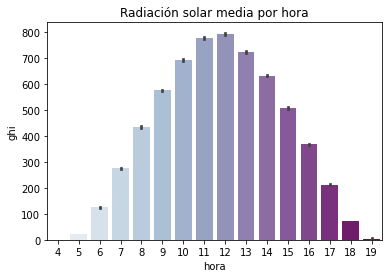

In [52]:
ax = plt.axes()
sns.barplot(x = "hora", y = 'ghi', data = df_soda, palette = "BuPu", ax = ax)
ax.set_title('Radiación solar media por hora')
plt.show()

# Unión de datasets
<div style = "float:right"><a style="text-decoration:none" href = "#Preparación-de-los-datos-para-los-modelos-de-predicción">

Los datasets a unir son:
   - ``df_soda``: Variable objetivo nº1. Radiación global en terreno horizontal en W/m² para cada hora y estación meteorológica.
   - ``df_objetivos``: Variable objetivo nº2. Temperatura media en Cº.
   - ``df_clima``: Datos climaticos de los 5 días anteriores al que se realiza la predicción (día anterior al día que se desea predecir).
   - ``df_pred``: Predicciones climáticas del día que se realiza la predicción (día anterior al día que se desea predecir) y el siguiente.
   - ``df_aemet``: Datos de radiación horaria en W/m² del día anterior al que se realiza la predicción (día anterior al día que se desea predecir) para cada hora y estación meteorológica.
   - ``df_rad_2``: Datos de radiación horaria en W/m² de dos días antes al que se realiza la predicción (día anterior al día que se desea predecir) para cada hora y estación meteorológica.

In [53]:
print("Variable objetivo radiación")
print(df_soda.head())

print("Variables objetivo temperatura ambiente y velocidad de viento")
print(df_objetivos.head())

print("Datos climaticos de los 5 días anteriores")
print(df_clima.head())

print("Predicciones climáticas del día que se realiza la predicción y el siguiente")
print(df_pred.head())

print("Datos de radiación horaria del día anterior")
print(df_aemet.head())

print("Datos de radiación horaria de tres días antes")
print(df_rad_2.head())

Variable objetivo radiación
        ghi indicativo  hora   fecha_rad
0    0.0000      0252D     4  2021-04-05
1    6.3289      0252D     5  2021-04-05
2  120.0964      0252D     6  2021-04-05
3  303.6657      0252D     7  2021-04-05
4  484.0124      0252D     8  2021-04-05
Variables objetivo temperatura ambiente y velocidad de viento
    fecha_rad  hora indicativo  temp_objetivo
0  2021-04-04     4      0252D          11.15
1  2021-04-04     5      0252D          11.44
2  2021-04-04     6      0252D          11.26
3  2021-04-04     7      0252D          11.84
4  2021-04-04     8      0252D          13.26
Datos climaticos de los 5 días anteriores
    fecha_rad  hora fecha prediccion indicativo  temp_d-1  feels_like_d-1  \
0  2021-04-06     4       2021-04-05      0252D     11.15            9.41   
1  2021-04-06     5       2021-04-05      0252D     11.44            9.42   
2  2021-04-06     6       2021-04-05      0252D     11.26           10.73   
3  2021-04-06     7       2021-04-05  

Se eliminan las columnas innecesarias

In [54]:
df_clima.drop(['fecha prediccion'], axis = 1, inplace = True)

In [55]:
df_pred.drop(['fecha prediccion'], axis = 1, inplace = True)

In [56]:
df_aemet.drop(['fecha'], axis = 1, inplace = True)
df_aemet.drop(['estacion'], axis = 1, inplace = True)

In [57]:
print("Variable objetivo radiación")
print(df_soda.shape)

print("Variables objetivo temperatura ambiente y velocidad de viento")
print(df_objetivos.shape)

print("Datos climaticos de los 5 días anteriores")
print(df_clima.shape)

print("Predicciones climáticas del día que se realiza la predicción y el siguiente")
print(df_pred.shape)

print("Datos de radiación horaria del día anterior")
print(df_aemet.shape)

print("Datos de radiación horaria de dos días antes")
print(df_rad_2.shape)

Variable objetivo radiación
(207440, 4)
Variables objetivo temperatura ambiente y velocidad de viento
(272352, 4)
Datos climaticos de los 5 días anteriores
(272352, 61)
Predicciones climáticas del día que se realiza la predicción y el siguiente
(272912, 16)
Datos de radiación horaria del día anterior
(32106, 6)
Datos de radiación horaria de dos días antes
(207440, 4)


Se unen los diferentes dataframes por la columna ``fecha_rad`` (fecha de la radiación a predecir), la ``hora`` y el ``indicativo``/``indicativo_rad`` de estación meteorológica/de radiación.

In [95]:
df_total = pd.merge(df_clima, df_pred, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,2021-04-06,4,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,11.52,9.78,1026,68,278.98,42,9770.795014,1.12,338,1.18,802,0201D,41.5875,2.54,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,2021-04-06,5,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.782415,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.782415,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.782415,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9770.795014,1.02,336,1.10,800,0201D,41.5875,2.54,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,2021-04-06,6,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.782415,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.782415,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.782415,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.782415,800,11.46,9.81,1026,68,278.92,41,9770.795014,0.97,324,1.07,802,0201D,41.5875,2.54,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,2021-04-06,7,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.782415,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.782415,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.782415,800,12.89,11.65,1026,64,279.40,47,9770.795014,0.54,329,0.85,802,0201D,41.5875,2.54,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,2021-04-06,8,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.782415,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.782415,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.782415,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.782415,800,14.37,13.27,1026,58,279.37,54,9770.795014,0.32,121,0.67,803,0201D,41.5875,2.54,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


In [96]:
df_total.shape

(262592, 74)

In [97]:
df_total = pd.merge(df_total, df_aemet, how = "inner", on = ["fecha_rad", "hora", "indicativo_rad"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1
0,2021-04-06,4,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.782415,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.782415,800,11.52,9.78,1026,68,278.98,42,9770.795014,1.12,338,1.18,802,0201D,41.587500,2.540000,11.725,10.960,1014.0,77.0,280.500,0.0,31.5,10000.0,2.565,168.5,3.325,0.0,801.5,0.0,0.0,330.246106
1,2021-04-06,4,0076,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,12.33,9.09,1013,62,278.42,20,10000.0,3.09,330,4.782415,801,10.03,5.31,1020,71,278.17,0,10000.0,5.14,330,4.782415,800,13.52,12.24,1026,69,281.10,74,9770.795014,1.14,59,1.24,803,0201D,41.292778,2.070000,13.970,13.250,1013.5,70.0,281.420,0.0,42.0,10000.0,4.070,147.0,5.060,0.0,801.5,0.0,0.0,330.246106
2,2021-04-06,4,0200E,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.57,9.38,1014,62,278.64,20,10000.0,3.09,330,4.782415,801,10.26,5.58,1020,71,278.39,0,10000.0,5.14,330,4.782415,800,11.10,9.29,1026,63,277.48,61,9770.795014,0.79,25,0.98,803,0201D,41.418333,2.124167,11.915,10.825,1014.0,63.5,279.235,0.0,42.5,10000.0,2.285,145.0,3.165,0.0,802.0,0.0,0.0,330.246106
3,2021-04-06,4,0201D,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,12.61,9.43,1014,62,278.68,20,10000.0,3.09,330,4.782415,801,10.29,5.62,1020,71,278.42,0,10000.0,5.14,330,4.782415,800,13.13,11.87,1026,66,280.08,60,9770.795014,0.77,37,1.00,803,0201D,41.390556,2.200000,13.885,13.035,1013.5,65.5,280.420,0.0,43.5,10000.0,2.880,147.5,3.745,0.0,802.0,0.0,0.0,330.246106
4,2021-04-06,4,0149X,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.28,6.77,1014,76,278.42,0,10000.0,2.06,290,4.782415,800,8.10,5.69,1020,75,277.09,0,10000.0,1.54,310,4.782415,800,8.92,7.04,1026,68,276.49,27,9770.795014,0.62,346,0.68,802,0201D,41.720000,1.840278,9.715,8.730,1014.5,70.0,276.985,0.0,44.0,10000.0,1.550,298.0,1.690,0.0,802.0,0.0,0.0,330.246106


In [98]:
df_total.shape

(253111, 77)

In [99]:
df_total = pd.merge(df_total, df_rad_2, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.782415,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.782415,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,12.53,9.62,1015,53,276.37,70,9770.795014,2.06,12,2.33,803,0201D,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,330.246106,0.0
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.782415,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.782415,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,14.44,11.15,1015,58,279.44,69,9770.795014,3.48,47,3.68,803,0201D,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,330.246106,0.0
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.782415,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.782415,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.19,8.87,1015,47,274.37,60,9770.795014,2.17,34,2.37,803,0201D,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,330.246106,0.0
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,14.08,11.07,1015,52,277.53,64,9770.795014,2.51,40,2.73,803,0201D,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,330.246106,0.0
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.782415,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.782415,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.95,7.33,1016,58,275.23,63,9770.795014,1.37,3,1.44,803,0201D,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,330.246106,0.0


In [100]:
df_total.shape

(184602, 78)

In [101]:
df_total = pd.merge(df_total, df_soda, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.782415,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.782415,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,12.53,9.62,1015,53,276.37,70,9770.795014,2.06,12,2.33,803,0201D,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,330.246106,0.0,0.0
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.782415,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.782415,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,14.44,11.15,1015,58,279.44,69,9770.795014,3.48,47,3.68,803,0201D,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,330.246106,0.0,0.0
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.782415,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.782415,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.19,8.87,1015,47,274.37,60,9770.795014,2.17,34,2.37,803,0201D,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,330.246106,0.0,0.0
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,14.08,11.07,1015,52,277.53,64,9770.795014,2.51,40,2.73,803,0201D,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,330.246106,0.0,0.0
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.782415,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.782415,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.95,7.33,1016,58,275.23,63,9770.795014,1.37,3,1.44,803,0201D,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,330.246106,0.0,0.0


In [102]:
df_total.shape

(163098, 79)

In [103]:
df_total = pd.merge(df_total, df_objetivos, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.782415,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.782415,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,12.53,9.62,1015,53,276.37,70,9770.795014,2.06,12,2.33,803,0201D,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.04
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.782415,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.782415,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,14.44,11.15,1015,58,279.44,69,9770.795014,3.48,47,3.68,803,0201D,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.28
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.782415,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.782415,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.19,8.87,1015,47,274.37,60,9770.795014,2.17,34,2.37,803,0201D,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.18
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,14.08,11.07,1015,52,277.53,64,9770.795014,2.51,40,2.73,803,0201D,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.23
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.782415,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.782415,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.95,7.33,1016,58,275.23,63,9770.795014,1.37,3,1.44,803,0201D,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,330.246106,0.0,0.0,6.46


Se elimina la columna innecesaria

In [104]:
df_total.drop(['indicativo_rad'], axis = 1, inplace = True)

In [105]:
df_total.shape

(156289, 79)

In [106]:
print("El número máximo de datos que puede haber en un día es {}".format(len(df_estaciones["indicativo"])*16))

El número máximo de datos que puede haber en un día es 4592


Se observa que hay fechas que disponen de menos datos que otras. En algunos casos será por el número de NAs que sontenían, en otros se deberá a fallo propio a la hora de descargar los datos (hay días que, por realizar pruebas o tener el ordenador haciendo otras cosas, he tenido errores de descarga).

In [107]:
df_total['fecha_rad'].value_counts()

2021-05-23    4592
2021-05-25    4592
2021-05-26    4592
2021-05-27    4588
2021-04-22    4576
2021-05-14    4576
2021-04-19    4569
2021-05-20    4567
2021-05-05    4544
2021-05-03    4544
2021-04-27    4544
2021-04-30    4544
2021-04-25    4544
2021-05-04    4544
2021-05-02    4540
2021-04-23    4540
2021-04-26    4537
2021-05-28    4532
2021-05-21    4518
2021-05-30    4516
2021-05-18    4496
2021-05-19    4491
2021-05-07    4468
2021-05-24    4448
2021-05-22    4406
2021-05-06    4384
2021-05-29    3629
2021-05-15    3456
2021-05-17    3392
2021-04-10    2160
2021-04-18    2160
2021-04-08    2160
2021-04-09    2160
2021-04-12    2160
2021-04-16    2160
2021-04-11    2160
2021-04-20    2160
2021-04-13    2160
2021-04-14    2048
2021-05-13    1416
2021-04-15    1392
2021-04-17    1388
2021-04-28    1312
2021-04-29     512
2021-05-01     512
Name: fecha_rad, dtype: int64

Se observa que hay estaciones que suelen disponer menos frecuentemente de datos que otras.

In [108]:
df_total['indicativo'].value_counts()

1208H    720
1428     720
1207U    720
0149X    720
0370B    720
1212E    720
0367     720
1210X    720
1437O    720
1283U    720
0200E    720
1393     720
1387     720
0076     720
0372C    720
1208A    720
1208     720
0229I    720
1473A    720
1351     720
1183X    720
0255B    720
1475X    720
0324A    720
0002I    720
0252D    720
0201D    720
1387E    720
1221D    720
1400     720
0016A    707
1505     688
1059X    688
1109     688
2444     688
2331     688
2235U    688
2298     688
2811A    688
1690A    688
1484C    688
2946X    688
2444C    688
1083L    688
1484     688
1690B    688
1078I    688
2916A    688
2870     688
1700X    688
1110     688
1495     688
2867     688
1111     688
1159     688
2491C    688
2462     687
2465     687
2465A    687
2150H    687
2661     682
2661B    682
2630X    682
1331A    678
2117D    672
2401     672
2400E    672
2030     672
2374X    672
2755X    666
1024E    665
1057B    665
1055B    665
1014     665
1082     665
1050J    665
1037Y    665

Se observa que hay algunas horas que suelen disponer menos frecuentemente de datos que otras.

In [109]:
df_total['hora'].value_counts()

11    9788
14    9781
13    9781
10    9778
16    9776
15    9776
12    9771
9     9771
17    9766
18    9765
8     9764
7     9764
6     9762
19    9758
4     9745
5     9743
Name: hora, dtype: int64

Se comprueba que algunas de las diferentes variables guardan correlación entre si, como la sensación térmica y la temperatura ambiente.

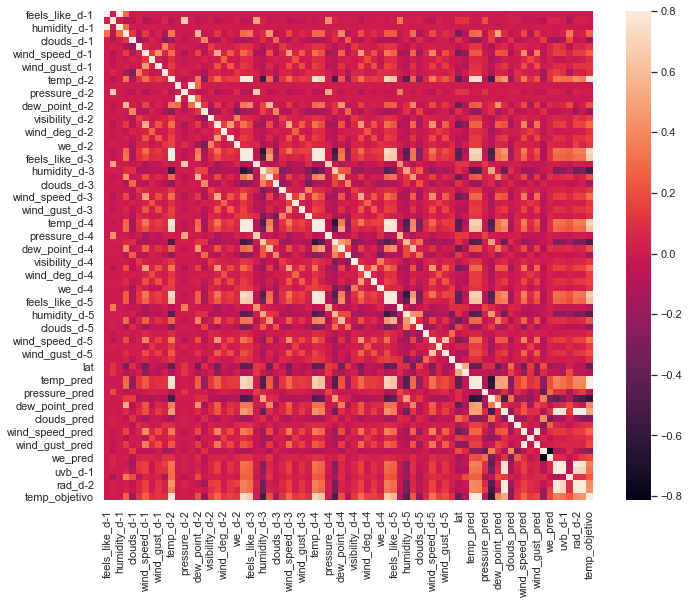

In [110]:
corrmat = df_total[df_total.columns[4:]].corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True);

Por tanto, se **reducirá la dimensionalidad** del dataset antes de entrenar los modelos

Se comprueba la correlación que hay entre la variable objetivo de radiación y las que se utilizarán para la predicción. La más significativa es la predicción de radiación UV para el día a predecir.

In [111]:
corr = abs(df_total.corr())
corr[['ghi']].sort_values(by = 'ghi',ascending = False).style.background_gradient()

,ghi
ghi,1.000000
uvi_pred,0.867755
rad_d-2,0.820034
rad_d-1,0.779625
uvb_d-1,0.708036
humidity_pred,0.504709
temp_objetivo,0.446894
temp_pred,0.408483
feels_like_pred,0.388125
temp_d-1,0.370269


Se comprueba la correlación que hay entre la variable objetivo de temperatura ambiente y las que se utilizarán para la predicción. La más significativa es la predicción de temperatura para el día a predecir.

In [112]:
corr = abs(df_total.corr())
corr[['temp_objetivo']].sort_values(by = 'temp_objetivo',ascending = False).style.background_gradient()

,temp_objetivo
temp_objetivo,1.000000
temp_pred,0.884172
feels_like_pred,0.877063
temp_d-1,0.803588
temp_d-2,0.771809
temp_d-3,0.731832
temp_d-4,0.702323
temp_d-5,0.660548
feels_like_d-3,0.659063
feels_like_d-4,0.622849


### Gestión de NAs

In [76]:
total = df_total.isnull().sum().sort_values(ascending = False)
percent = (df_total.isnull().sum()/df_total.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
temp_objetivo,0,0.0
humidity_d-3,0,0.0
wind_speed_d-2,0,0.0
wind_deg_d-2,0,0.0
wind_gust_d-2,0,0.0
we_d-2,0,0.0
temp_d-3,0,0.0
feels_like_d-3,0,0.0
pressure_d-3,0,0.0
dew_point_d-3,0,0.0


No hay NAs

In [130]:
df_total.describe()

,hora,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
count,156289.000000,156289.000000,1.562890e+05,156289.000000,1.562890e+05,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,1.562890e+05,156289.000000,1.562890e+05,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000,156289.000000
mean,11.502428,15.937985,-2.314231e+13,1014.096865,-2.360594e+14,281.397306,38.680547,9774.365083,3.506160,164.972301,4.835596,776.090275,15.751221,-2.314925e+13,1014.005048,-2.360594e+14,281.191831,38.755632,9771.894861,3.517434,168.299912,4.851227,774.707798,15.587827,12.817083,1013.550711,64.502121,281.161446,39.668518,9754.277669,3.502003,169.605577,4.846012,772.506690,15.583533,12.824135,1012.959754,65.186814,281.342077,40.118537,9738.599268,3.551467,172.781117,4.890312,769.140982,15.546892,12.605499,1013.927768,62.682390,280.765078,49.516025,9811.307168,3.627431,185.615386,4.847582,769.653994,39.951509,-4.100046,15.828209,15.048853,1016.322489,61.932721,280.647019,2.665292,63.175739,9913.270582,3.230846,179.238616,4.249200,0.124916,766.999363,378.679739,0.062120,328.891446,383.434162,387.348066,16.509853
std,4.607693,5.362302,4.574447e+15,9.945568,4.666071e+16,4.747639,35.686258,943.956361,2.454263,113.366033,1.917727,86.179110,5.332747,4.575821e+15,10.156136,4.666071e+16,4.734122,35.495299,941.642550,2.450686,113.167537,1.951625,87.837280,5.293997,5.466125,10.458427,20.448035,4.541079,35.603668,1000.019801,2.431712,112.676006,1.939891,91.239626,5.271047,5.453291,10.780822,20.303520,4.563918,35.578005,1046.869603,2.471336,112.914194,2.027941,95.633165,5.552244,5.823343,9.350588,19.359905,4.793131,38.249521,547.813472,2.441464,108.340681,2.678836,94.556146,3.439656,3.970405,5.412665,5.654675,4.698440,17.402663,3.973222,2.725633,27.987467,547.596382,1.878799,87.767133,2.364351,0.204912,75.889096,327.725980,0.060553,29.507291,319.795594,321.212155,5.427999
min,4.000000,-5.000000,-9.082920e+17,834.000000,-9.223372e+18,0.000000,0.000000,50.000000,0.020000,0.000000,0.000000,300.000000,-5.000000,-9.082920e+17,834.000000,-9.223372e+18,0.000000,0.000000,50.000000,0.010000,0.000000,0.000000,300.000000,-4.730000,-14.240000,834.000000,4.000000,250.210000,0.000000,50.000000,0.020000,0.000000,0.000000,300.000000,-5.000000,-14.240000,834.000000,4.000000,250.210000,0.00

Se convierten en strings los nombres de las columnas

In [114]:
df_total.columns = [str(i) for i in df_total.columns]

Se investiga si las diferentes variables a utilizar siguen una distribución normal

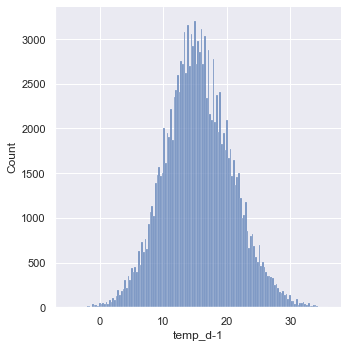

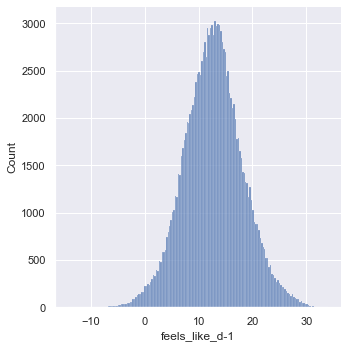

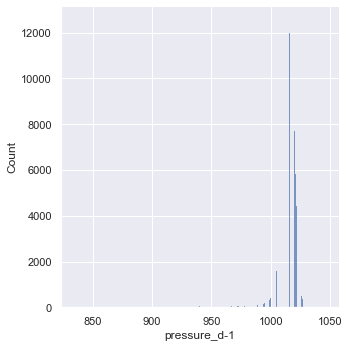

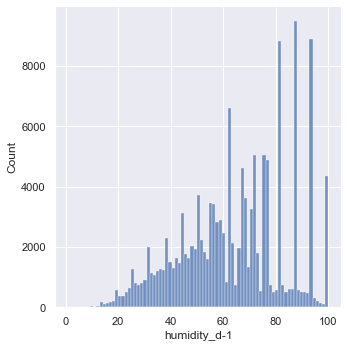

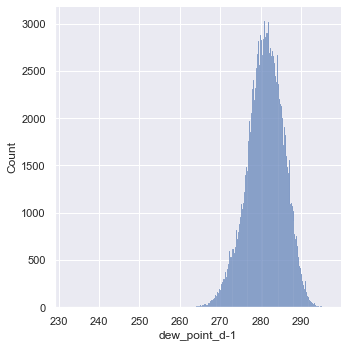

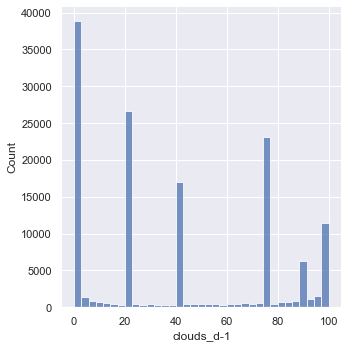

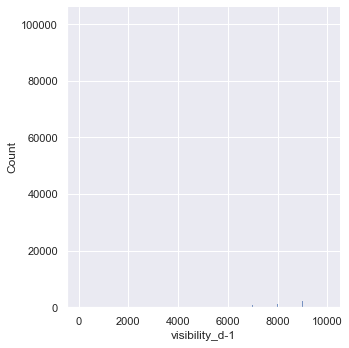

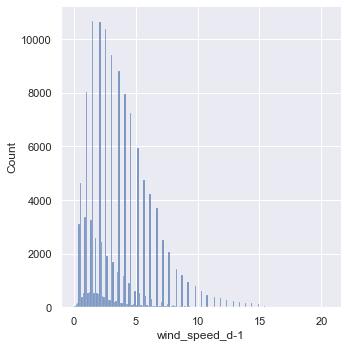

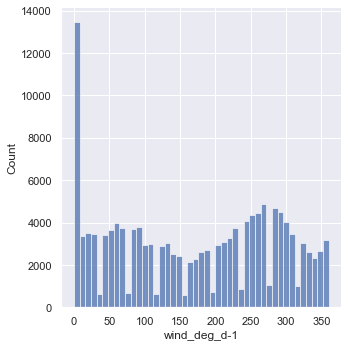

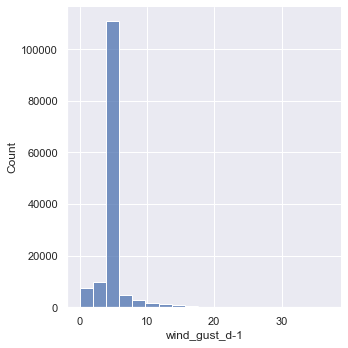

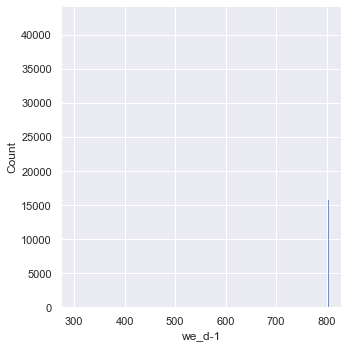

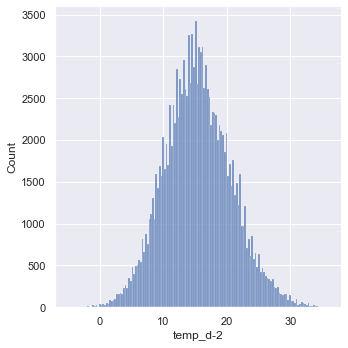

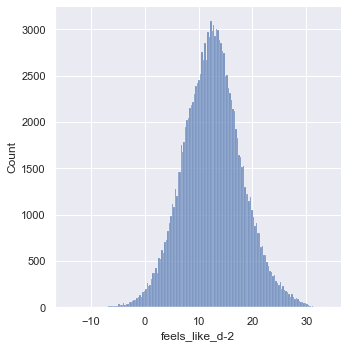

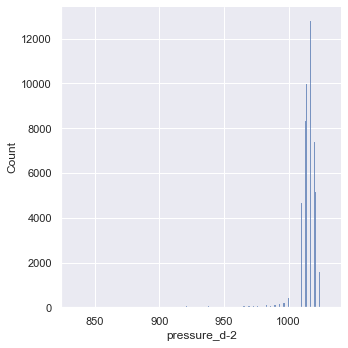

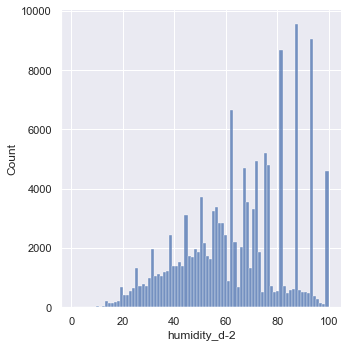

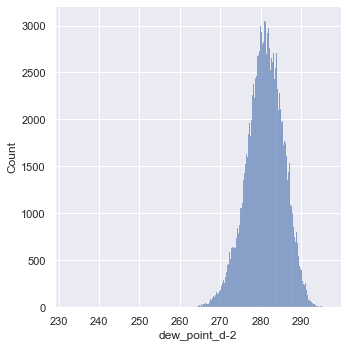

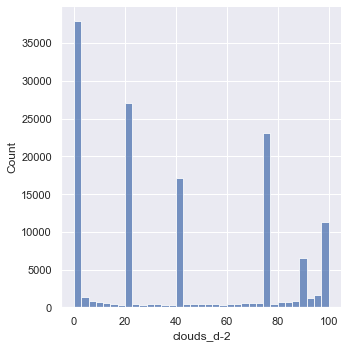

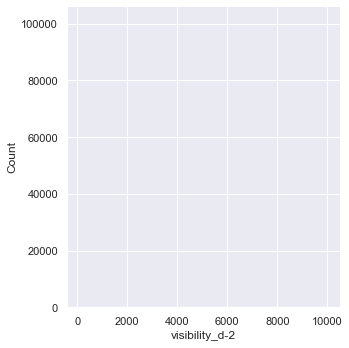

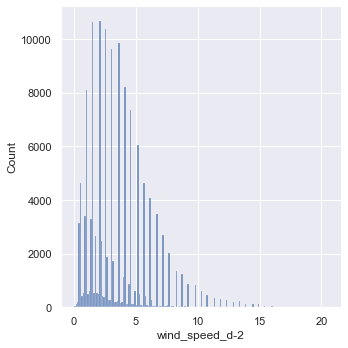

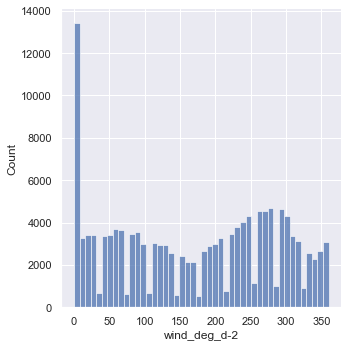

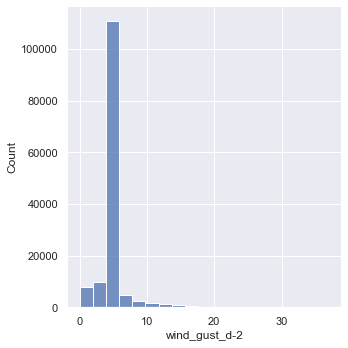

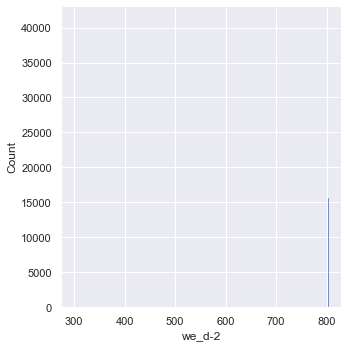

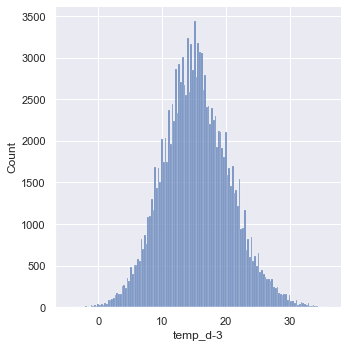

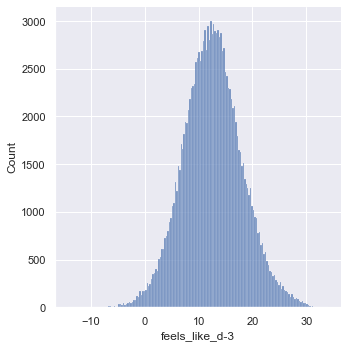

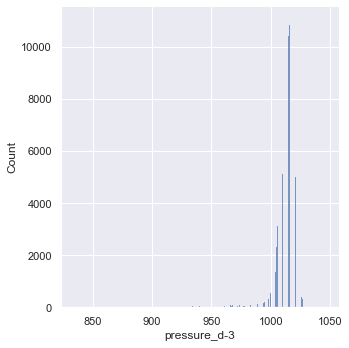

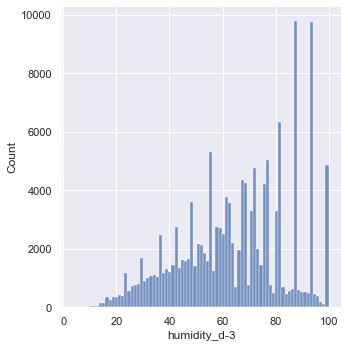

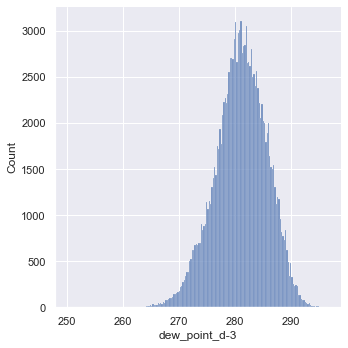

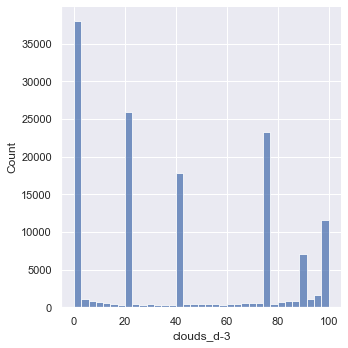

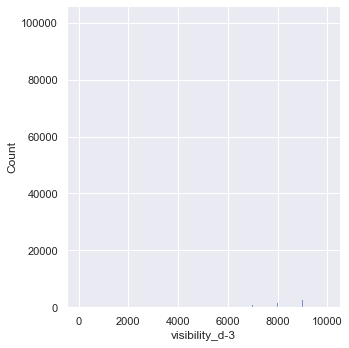

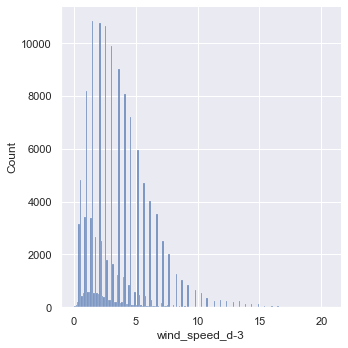

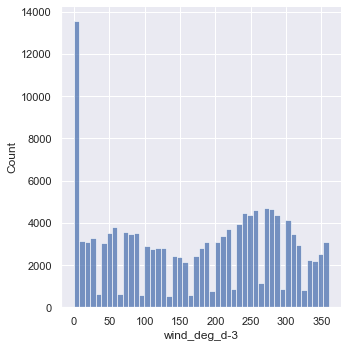

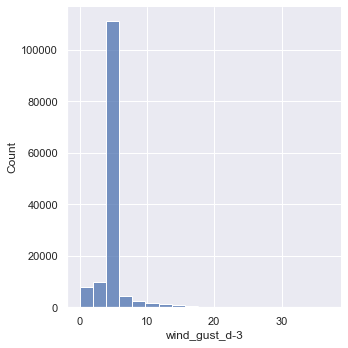

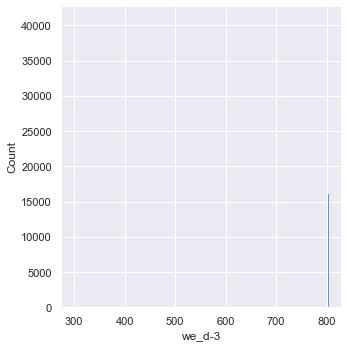

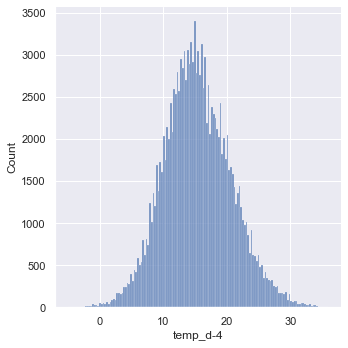

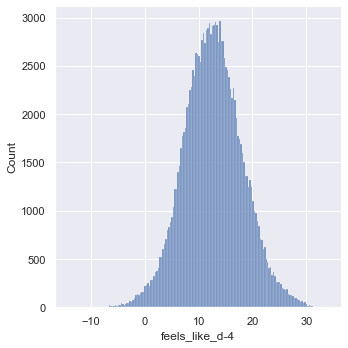

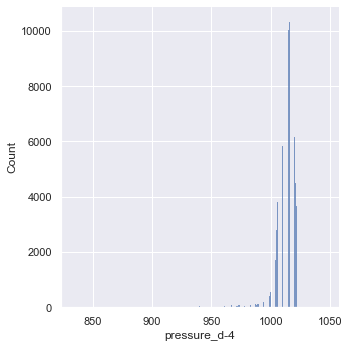

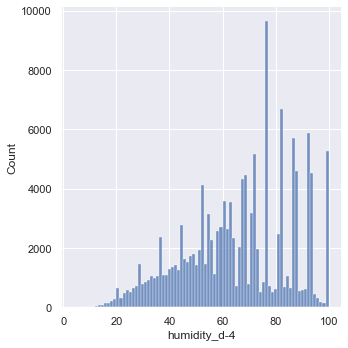

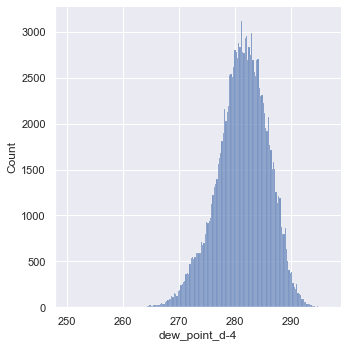

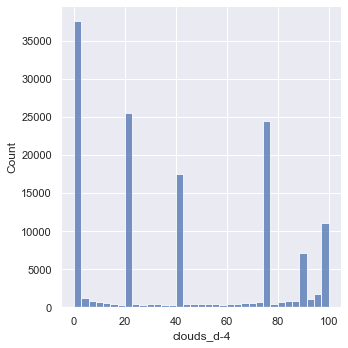

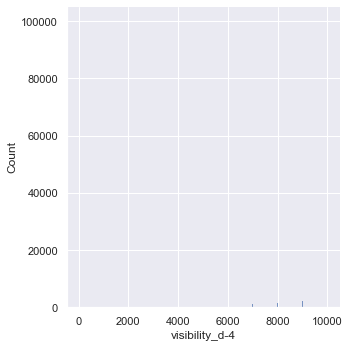

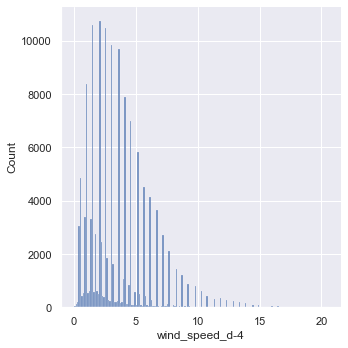

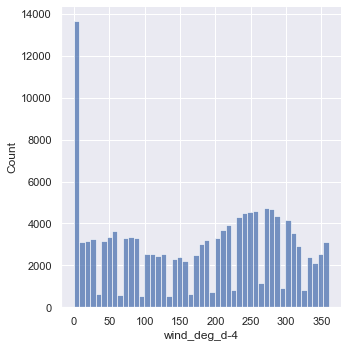

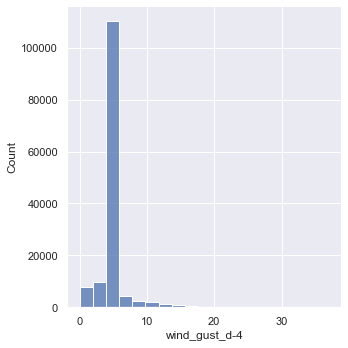

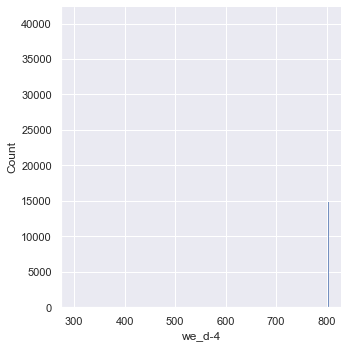

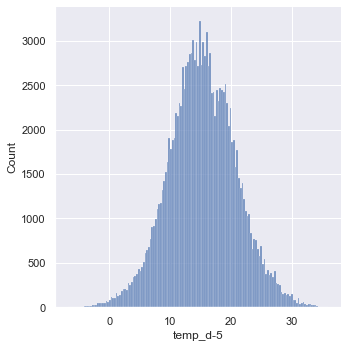

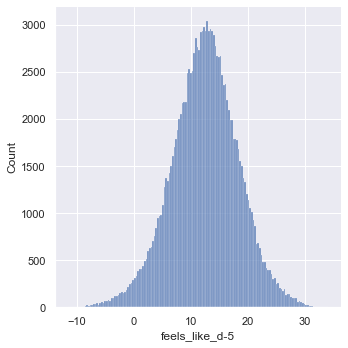

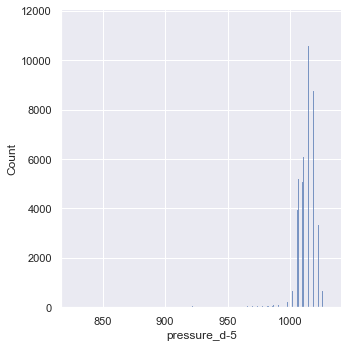

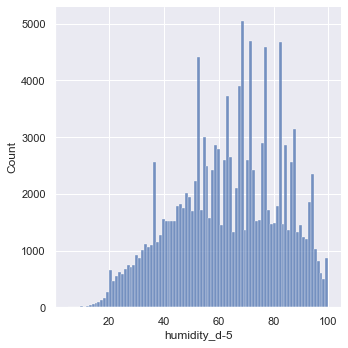

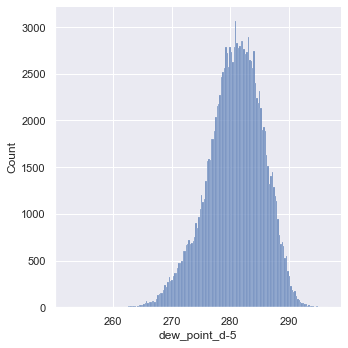

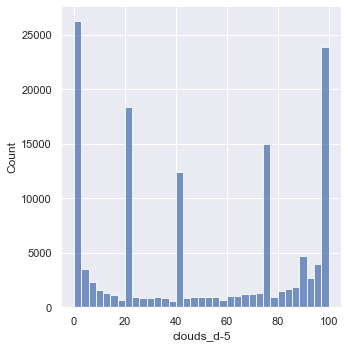

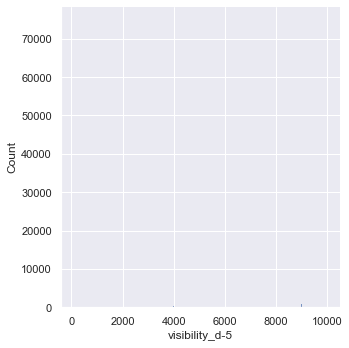

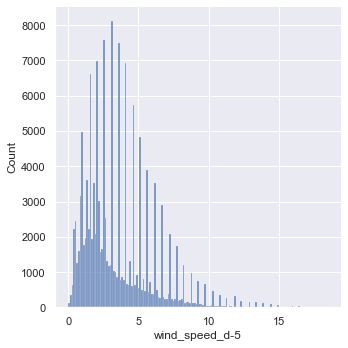

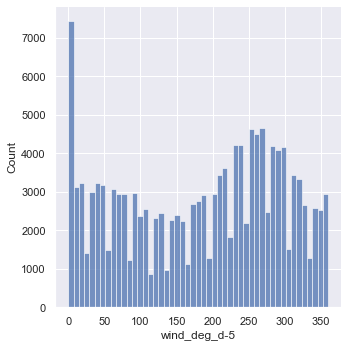

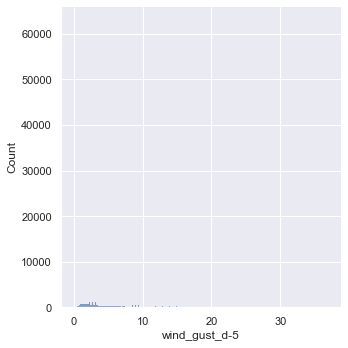

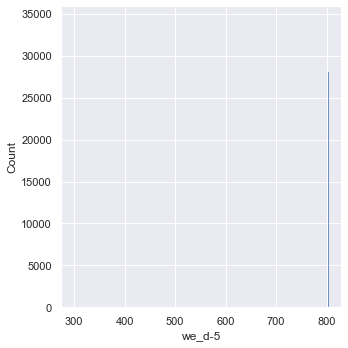

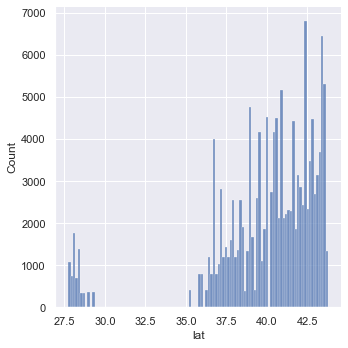

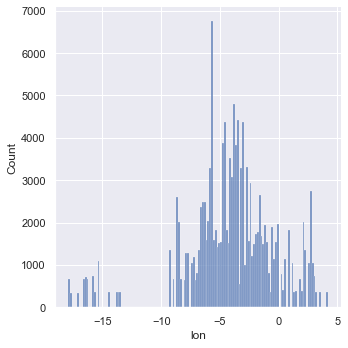

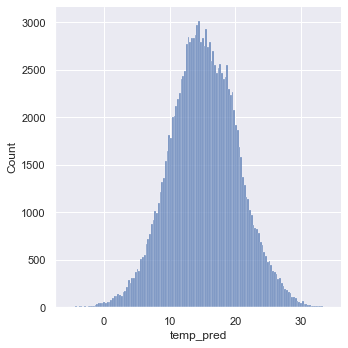

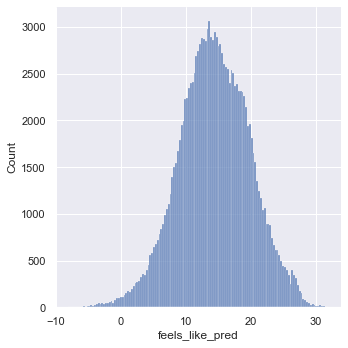

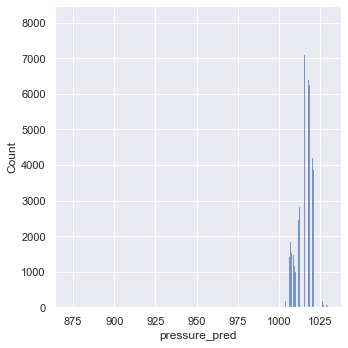

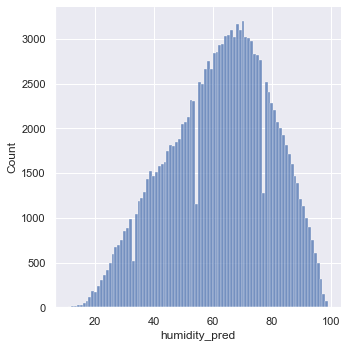

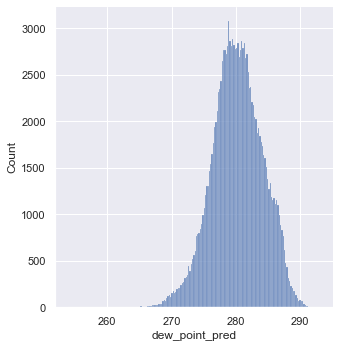

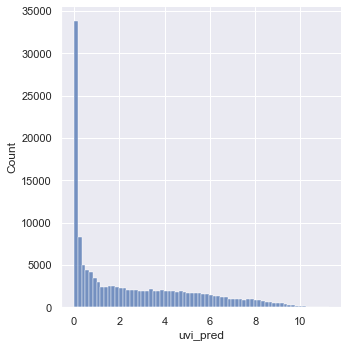

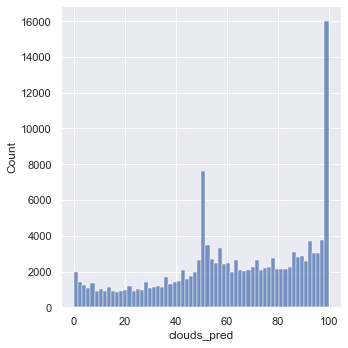

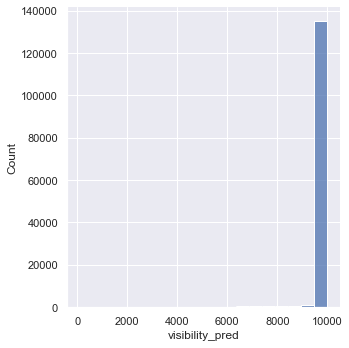

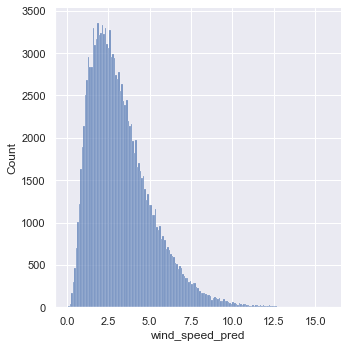

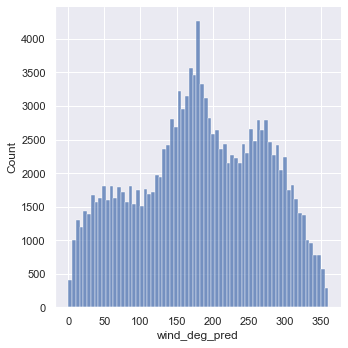

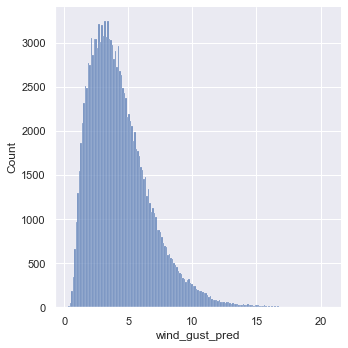

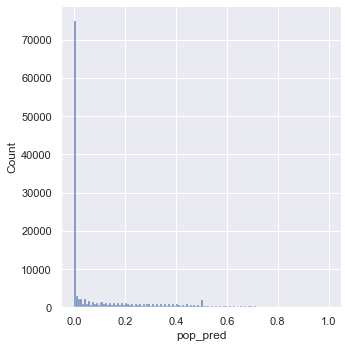

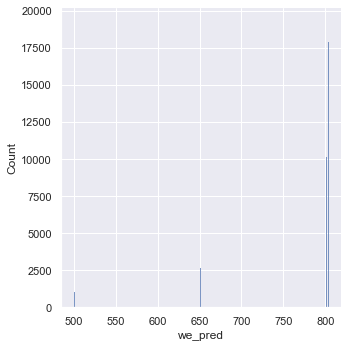

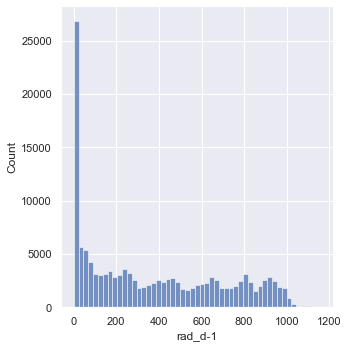

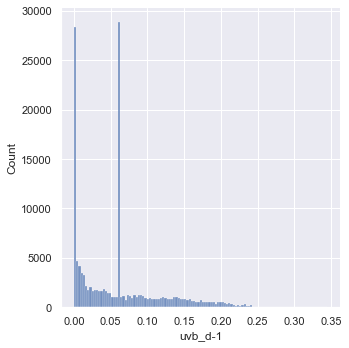

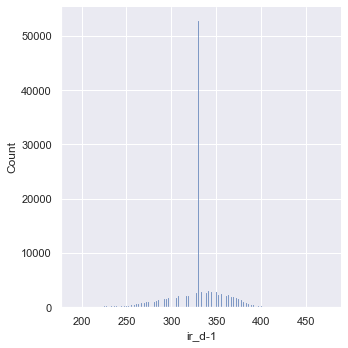

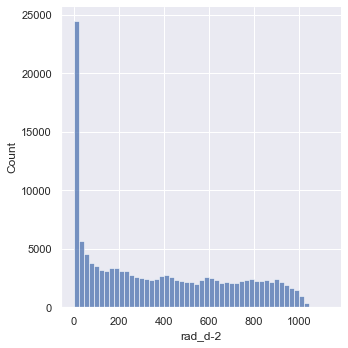

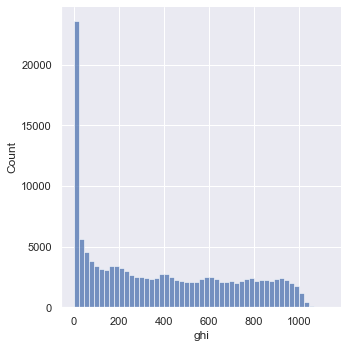

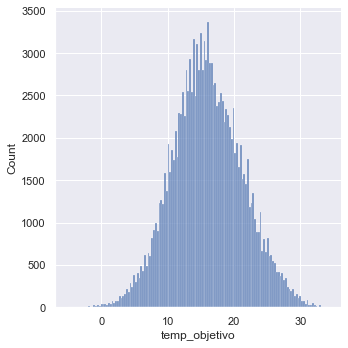

In [139]:
for i in range(3, len(df_total.columns)):
        sns.set()
        cols = list(df_total.columns)[i]
        sns.displot(df_total[cols][:140000])
        plt.show();

In [140]:
df_total.shape

(156289, 79)

Se comprueba que no, por lo que también será necesario un proceso de **estandarización** de los datos.

Detalle de algunas componentes ejemplo:

<AxesSubplot:xlabel='pressure_d-2', ylabel='Count'>

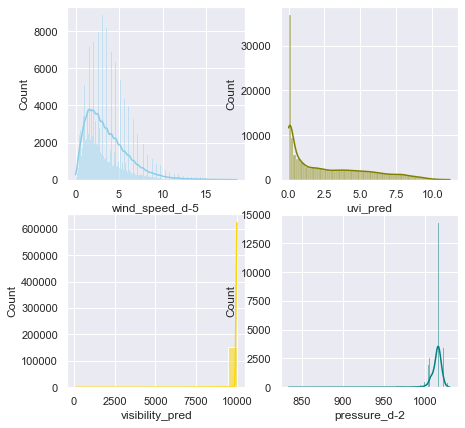

In [141]:
sns.set(style="darkgrid")
df = df_total

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data = df, x = "wind_speed_d-5", kde = True, color = "skyblue", ax = axs[0, 0])
sns.histplot(data = df, x = "uvi_pred", kde = True, color = "olive", ax = axs[0, 1])
sns.histplot(data = df, x = "visibility_pred", kde = True, color = "gold", ax = axs[1, 0])
sns.histplot(data = df, x = "pressure_d-2", kde = True, color = "teal", ax = axs[1, 1])

In [142]:
from scipy import stats

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


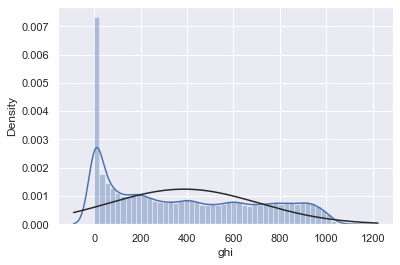

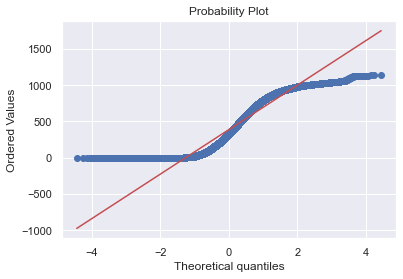

In [143]:
sns.distplot(df_total['ghi'], fit = stats.norm);
fig = plt.figure()
res = stats.probplot(df_total['ghi'], plot = plt)

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


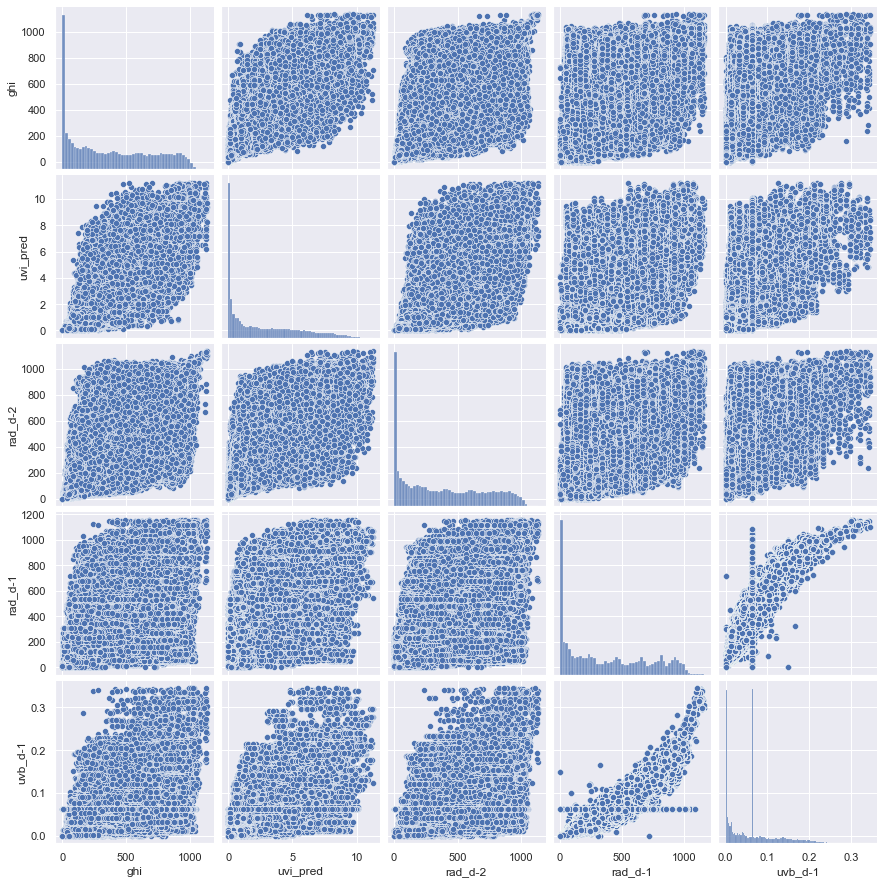

In [144]:
sns.set()
cols = ['ghi', "uvi_pred", "rad_d-2", "rad_d-1", "uvb_d-1"]
sns.pairplot(df_total[cols], size = 2.5)
plt.show();

# Función final
<div style = "float:right"><a style="text-decoration:none" href = "#Preparación-de-los-datos-para-los-modelos-de-predicción">

In [145]:
def merge_datasets(df_estaciones, df_estaciones_rad, df_clima, df_pred, df_aemet, df_soda):
    
    ## CLIMA ##
    print("Procesando CLIMA")
    
    # Se añade la columna de fechas del día a predecir al dataset de datos climatológicos
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha prediccion"]]
    df_clima.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Se renombran columnas y se convierten las temperaturas a grados Cº
    df_clima = df_clima.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
    
    df_clima["temp_d-1"] = df_clima["temp_d-1"] - 273.15
    df_clima["temp_d-2"] = df_clima["temp_d-2"] - 273.15
    df_clima["temp_d-3"] = df_clima["temp_d-3"] - 273.15
    df_clima["temp_d-4"] = df_clima["temp_d-4"] - 273.15
    df_clima["temp_d-5"] = df_clima["temp_d-5"] - 273.15
    df_clima["feels_like_d-1"] = df_clima["feels_like_d-1"] - 273.15
    df_clima["feels_like_d-2"] = df_clima["feels_like_d-2"] - 273.15
    df_clima["feels_like_d-3"] = df_clima["feels_like_d-3"] - 273.15
    df_clima["feels_like_d-4"] = df_clima["feels_like_d-4"] - 273.15
    df_clima["feels_like_d-5"] = df_clima["feels_like_d-5"] - 273.15
    
    # Se crea el nuevo dataframe con la columna objetivo de temperatura
    df_objetivos = pd.DataFrame(columns = ["hora", "indicativo", "temp_objetivo"])
    df_objetivos["hora"] = df_clima["hora"]
    df_objetivos["indicativo"] = df_clima["indicativo"]
    df_objetivos["temp_objetivo"] = df_clima["temp_d-1"]

    # Se añade la columna de fechas del día a predecir al dataset de datos climatológicos
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) - datetime.timedelta(days=1)).year), str((pd.to_datetime(f) - datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) - datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha prediccion"]]
    df_objetivos.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Se eliminan columnas innecesarias
    df_clima.drop(['fecha prediccion'], axis = 1, inplace = True)
    
    # Se añade la columna de indicativos de las estaciones de radiación más cercanas    
    df_clima["indicativo_rad"] = np.nan
    df_clima["lat"] = np.nan
    df_clima["lon"] = np.nan

    for i, fila in df_clima.iterrows():

        j = list(df_estaciones["indicativo"]).index(fila["indicativo"])
        lat = conversor_coordenadas(str(df_estaciones["latitud"].loc[j]))
        lon = conversor_coordenadas(str(df_estaciones["longitud"].loc[j]))
        
        df_clima.loc[i,"lat"] = lat
        df_clima.loc[i,"lon"] = lon
    
        dist = 99999999999999999999

        # Para cada fila, busco la estacion de radiación más cercana
        for k in range(0, len(df_estaciones_rad["indicativo"])): 
            lat_est = conversor_coordenadas(str(df_estaciones_rad["latitud"].loc[k]))
            lon_est = conversor_coordenadas(str(df_estaciones_rad["longitud"].loc[k]))

            distancia_prueba = distancia(lat, lon, lat_est, lon_est)
            if(distancia_prueba < dist):
                dist = distancia_prueba
                df_clima.loc[i, "indicativo_rad"] = df_estaciones_rad.loc[k, "indicativo"]

    ## PREDICCION ##  
    print("Procesando PREDICCION")
    # Se convierten las variables de temperatura a grados Cº        
    df_pred["temp_pred"] = df_pred["temp_pred"] - 273.15
    df_pred["feels_like_pred"] = df_pred["feels_like_pred"] - 273.15
    
    # Se añade la columna de fechas del día a predecir al dataset de predicciones climatológicos
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_pred["fecha prediccion"]]
    df_pred.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Se renombran columnas y eliminan las innecesarias
    df_pred = df_pred.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
    df_pred.drop(['fecha prediccion'], axis = 1, inplace = True)
    
    ## RADIACION DIA ANTERIOR ##
    print("Procesando RADIACION DIA ANTERIOR")
    # Se añade la columna de fechas del día a predecir al dataset de radiación de AEMET
    df_aemet = df_aemet.rename(columns={'indicativo':'indicativo_rad'})
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=2)).year), str((pd.to_datetime(f) + datetime.timedelta(days=2)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=2)).day).zfill(2)) for f in df_aemet["fecha"]]
    df_aemet.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Se renombran columnas 
    df_aemet = df_aemet.rename(columns={'GL': 'rad_d-1', 'UVB': 'uvb_d-1', 'IR': 'ir_d-1'})
    
    # Se eliminan las columnas innecesarias
    df_aemet.drop(['fecha'], axis = 1, inplace = True)
    df_aemet.drop(['estacion'], axis = 1, inplace = True)
    
    ## RADIACION ##
    print("Procesando RADIACION")
    # Se renombran columnas y eliminan las innecesarias
    df_soda = df_soda.rename(index = str, columns = {"estacion": "indicativo", "fecha": "fecha_rad"})
    df_soda.drop(['date'], axis=1, inplace = True)
    
    # Se crea un dataset que contenga la variable de radiación de tres días antes
    df_rad_2 = pd.DataFrame(columns = ["indicativo", "hora", "rad_d-2"])
    df_rad_2["indicativo"] = df_soda["indicativo"]
    df_rad_2["hora"] = df_soda["hora"]
    df_rad_2["rad_d-2"] = df_soda["ghi"]
    
    # Se añade la columna de fechas del día a predecir al dataset de radiación de tres días antes
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=3)).year), str((pd.to_datetime(f) + datetime.timedelta(days=3)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=3)).day).zfill(2)) for f in df_soda["fecha_rad"]]
    df_rad_2.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    ## MERGE ##
    print("Procesando MERGE")
    # Se unen los datasets
    df_total = pd.merge(df_clima, df_pred, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
    df_total = pd.merge(df_total, df_aemet, how = "inner", on = ["fecha_rad", "hora", "indicativo_rad"])
    df_total = pd.merge(df_total, df_rad_2, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
    df_total = pd.merge(df_total, df_soda, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
    df_total = pd.merge(df_total, df_objetivos, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
       
    df_total.drop(['indicativo_rad'], axis = 1, inplace = True)
    
    df_total.columns = [str(i) for i in df_total.columns]

    # Se guarda el nuevo dataframe
    nombre = './data/Modelo_2/Datos_modelo_2.csv'
    df_total.to_csv(nombre, index = False)
    
    return df_total
    

**PRECAUCIÓN:** Tarda horas en correr

In [146]:
import pandas as pd
import numpy as np
import random
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle as pk
pd.options.display.max_columns = None
pd.options.display.max_rows = None


hora_ini = 4
hora_fin = 20
%cd /home/dsc/git/TFM/

def distancia(lat1, lon1, lat2, lon2, distancia = "euclidea"):
    
    if(distancia == "euclidea"):
        dist = math.sqrt((lat1 - lat2)**2 + (lon1 -lon2)**2)
    
    elif(distancia == "manhattan"):
        dist = abs(lat1 - lat2) + abs(lon1 -lon2)
  
    return dist 

def conversor_coordenadas(coord):
    #Si coord es latitud, al norte del ecuador es siempre positiva
    #Si coord es longitud, al oeste del Meridiano 0º son negativas
    
    D = int(coord[0:2])
    M = float(coord[2:4])
    S = float(coord[4:6])
    
    #GMS a GD
    DD = float((D) + (M/60) + (S/3600))
        
    if(coord[6] == "S" or coord[6] == "W"):
            DD = -DD
            
    return DD

directorio = '/home/dsc/git/TFM/'

# Se importa el dataset de estaciones meteorológicas
df_estaciones = pd.read_csv(directorio + 'data/estaciones.csv')

# Se importa el dataset de estaciones de radiación
df_estaciones_rad = pd.read_csv(directorio + 'data/estaciones_rad.csv')
df_estaciones_rad.dropna(inplace = True)
df_estaciones_rad.reset_index(drop = True, inplace = True)

# Se importa el dataset de datos climáticos
df_clima = pd.read_csv('./data/Historicos_modelo_2/clima_por_horas.csv', sep=',')

# Se importa el dataset de datos de predicción climática
df_pred = pd.read_csv('./data/Historicos_modelo_2/pred_por_horas.csv', sep=',')

# Se importa el dataset de radiación de AEMET
df_aemet = pd.read_csv('./data/Historicos_modelo_2/rad_aemet_clean.csv', sep=',')

# Se importa el dataset de radiación objetivo
df_soda = pd.read_csv('./data/Historicos_modelo_2/rad_soda_clean.csv', sep=',')

df_total = merge_datasets(df_estaciones, df_estaciones_rad, df_clima, df_pred, df_aemet, df_soda)
df_total.head()

/home/dsc/git/TFM
Procesando CLIMA
Procesando PREDICCION
Procesando RADIACION DIA ANTERIOR
Procesando RADIACION
Procesando MERGE


,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.782415,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.782415,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,12.53,9.62,1015,53,276.37,70,9770.795014,2.06,12,2.33,803,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.04
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.782415,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.782415,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,14.44,11.15,1015,58,279.44,69,9770.795014,3.48,47,3.68,803,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.28
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.782415,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.782415,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.19,8.87,1015,47,274.37,60,9770.795014,2.17,34,2.37,803,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.18
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,14.08,11.07,1015,52,277.53,64,9770.795014,2.51,40,2.73,803,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.23
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.782415,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.782415,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.95,7.33,1016,58,275.23,63,9770.795014,1.37,3,1.44,803,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,330.246106,0.0,0.0,6.46


In [147]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156289 entries, 0 to 156288
Data columns (total 79 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fecha_rad        156289 non-null  object 
 1   hora             156289 non-null  int64  
 2   indicativo       156289 non-null  object 
 3   temp_d-1         156289 non-null  float64
 4   feels_like_d-1   156289 non-null  float64
 5   pressure_d-1     156289 non-null  int64  
 6   humidity_d-1     156289 non-null  int64  
 7   dew_point_d-1    156289 non-null  float64
 8   clouds_d-1       156289 non-null  int64  
 9   visibility_d-1   156289 non-null  float64
 10  wind_speed_d-1   156289 non-null  float64
 11  wind_deg_d-1     156289 non-null  int64  
 12  wind_gust_d-1    156289 non-null  float64
 13  we_d-1           156289 non-null  int64  
 14  temp_d-2         156289 non-null  float64
 15  feels_like_d-2   156289 non-null  float64
 16  pressure_d-2     156289 non-null  int6

### Sanity check

In [148]:
print('Años distintos: ', pd.to_datetime([year for year in pd.to_datetime(df_total['fecha_rad'])]).year.nunique())
print('Meses diferentes:', pd.to_datetime([year for year in pd.to_datetime(df_total['fecha_rad'])]).month.nunique())
print('Debe haber 31 días distintos:', pd.to_datetime([year for year in pd.to_datetime(df_total['fecha_rad'])]).day.nunique())


print('Solo debe haber horas distintas dentro de las horas de filtrado: ', df_total['hora'].nunique())

Años distintos:  1
Meses diferentes: 2
Debe haber 31 días distintos: 30
Solo debe haber horas distintas dentro de las horas de filtrado:  16
